In [1]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import random
from datetime import datetime
from scipy import stats

warnings.filterwarnings('ignore')

In [2]:
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

output_directory_name =  'DAoptostimulation_Mar22'

outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    print('I dont find this')
else:
    # Read the dataframe
    AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')
    print('Dataframe read')

Dataframe read


In [3]:
# Correct a session that was not properly marked
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-06 Mar30 15:28', 'Stimulation'] = 'Right'

In [4]:
# Correct data for April first, where fibers where connected the other way around
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-01 Apr01 13:54', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-02 Apr01 13:54', 'Stimulation'] = 'Left'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-03 Apr01 14:50', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-04 Apr01 14:40', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-05 Apr01 15:27', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-06 Apr01 15:35', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-07 Apr01 16:12', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-08 Apr01 16:17', 'Stimulation'] = 'Left'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-09 Apr01 16:49', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-10 Apr01 16:54', 'Stimulation'] = 'Right'

### Analysis of 'Just One Port' stimulation

In [5]:
# In this version of the task, mice receive 150 initial trials without stimulation, and then ports in one port are
# always stimulated

In [6]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [7]:
# Select only sessions with more than 350 trials
tr_below = 325
tisessdf = pulledData.groupby('SessionID').max().reset_index()[['SessionID', 'TrialIndex']]
sess_to_remove = list(tisessdf[tisessdf.TrialIndex < tr_below]['SessionID'])
pulledData = pulledData[~pulledData.SessionID.isin(sess_to_remove)]

In [8]:
#Select only sessions over date (less stimulation, physiological parameters?)
str_format = '%b%d %H:%M'
limit_date = 'Mar29 00:01'
session_times = [datetime.strptime(x, str_format) for x in pulledData.SessionTime.unique()]
date_mask = [x > datetime.strptime(limit_date, str_format) for x in session_times]
selected_dates = [x.strftime(str_format) for x in np.array(session_times)[date_mask]]
pulledData = pulledData[pulledData.SessionTime.isin(selected_dates)]

In [9]:
# Select cases when stimulation was only on one side and 150 trials were w/o opto
jop_mask = []
fot_mask = []
for x in pulledData.FullGUI:
    if 'JustOnePort' in x and x['JustOnePort'] == 1:
        jop_mask.append(True)
    else:
        jop_mask.append(False)
        
    if 'FreeOptoIniTrials' in x and x['FreeOptoIniTrials'] == 150:
        fot_mask.append(True)
    else:
        fot_mask.append(False)

pulledData = pulledData.iloc[np.logical_and(jop_mask, fot_mask)]

In [10]:
# Select how to group trial numbers to compare
ini_trials = 150 # initial trials without stimulation
ao_trials = 225 # trials without stimulation, after some sampling

Progress: [####################] 100.0%


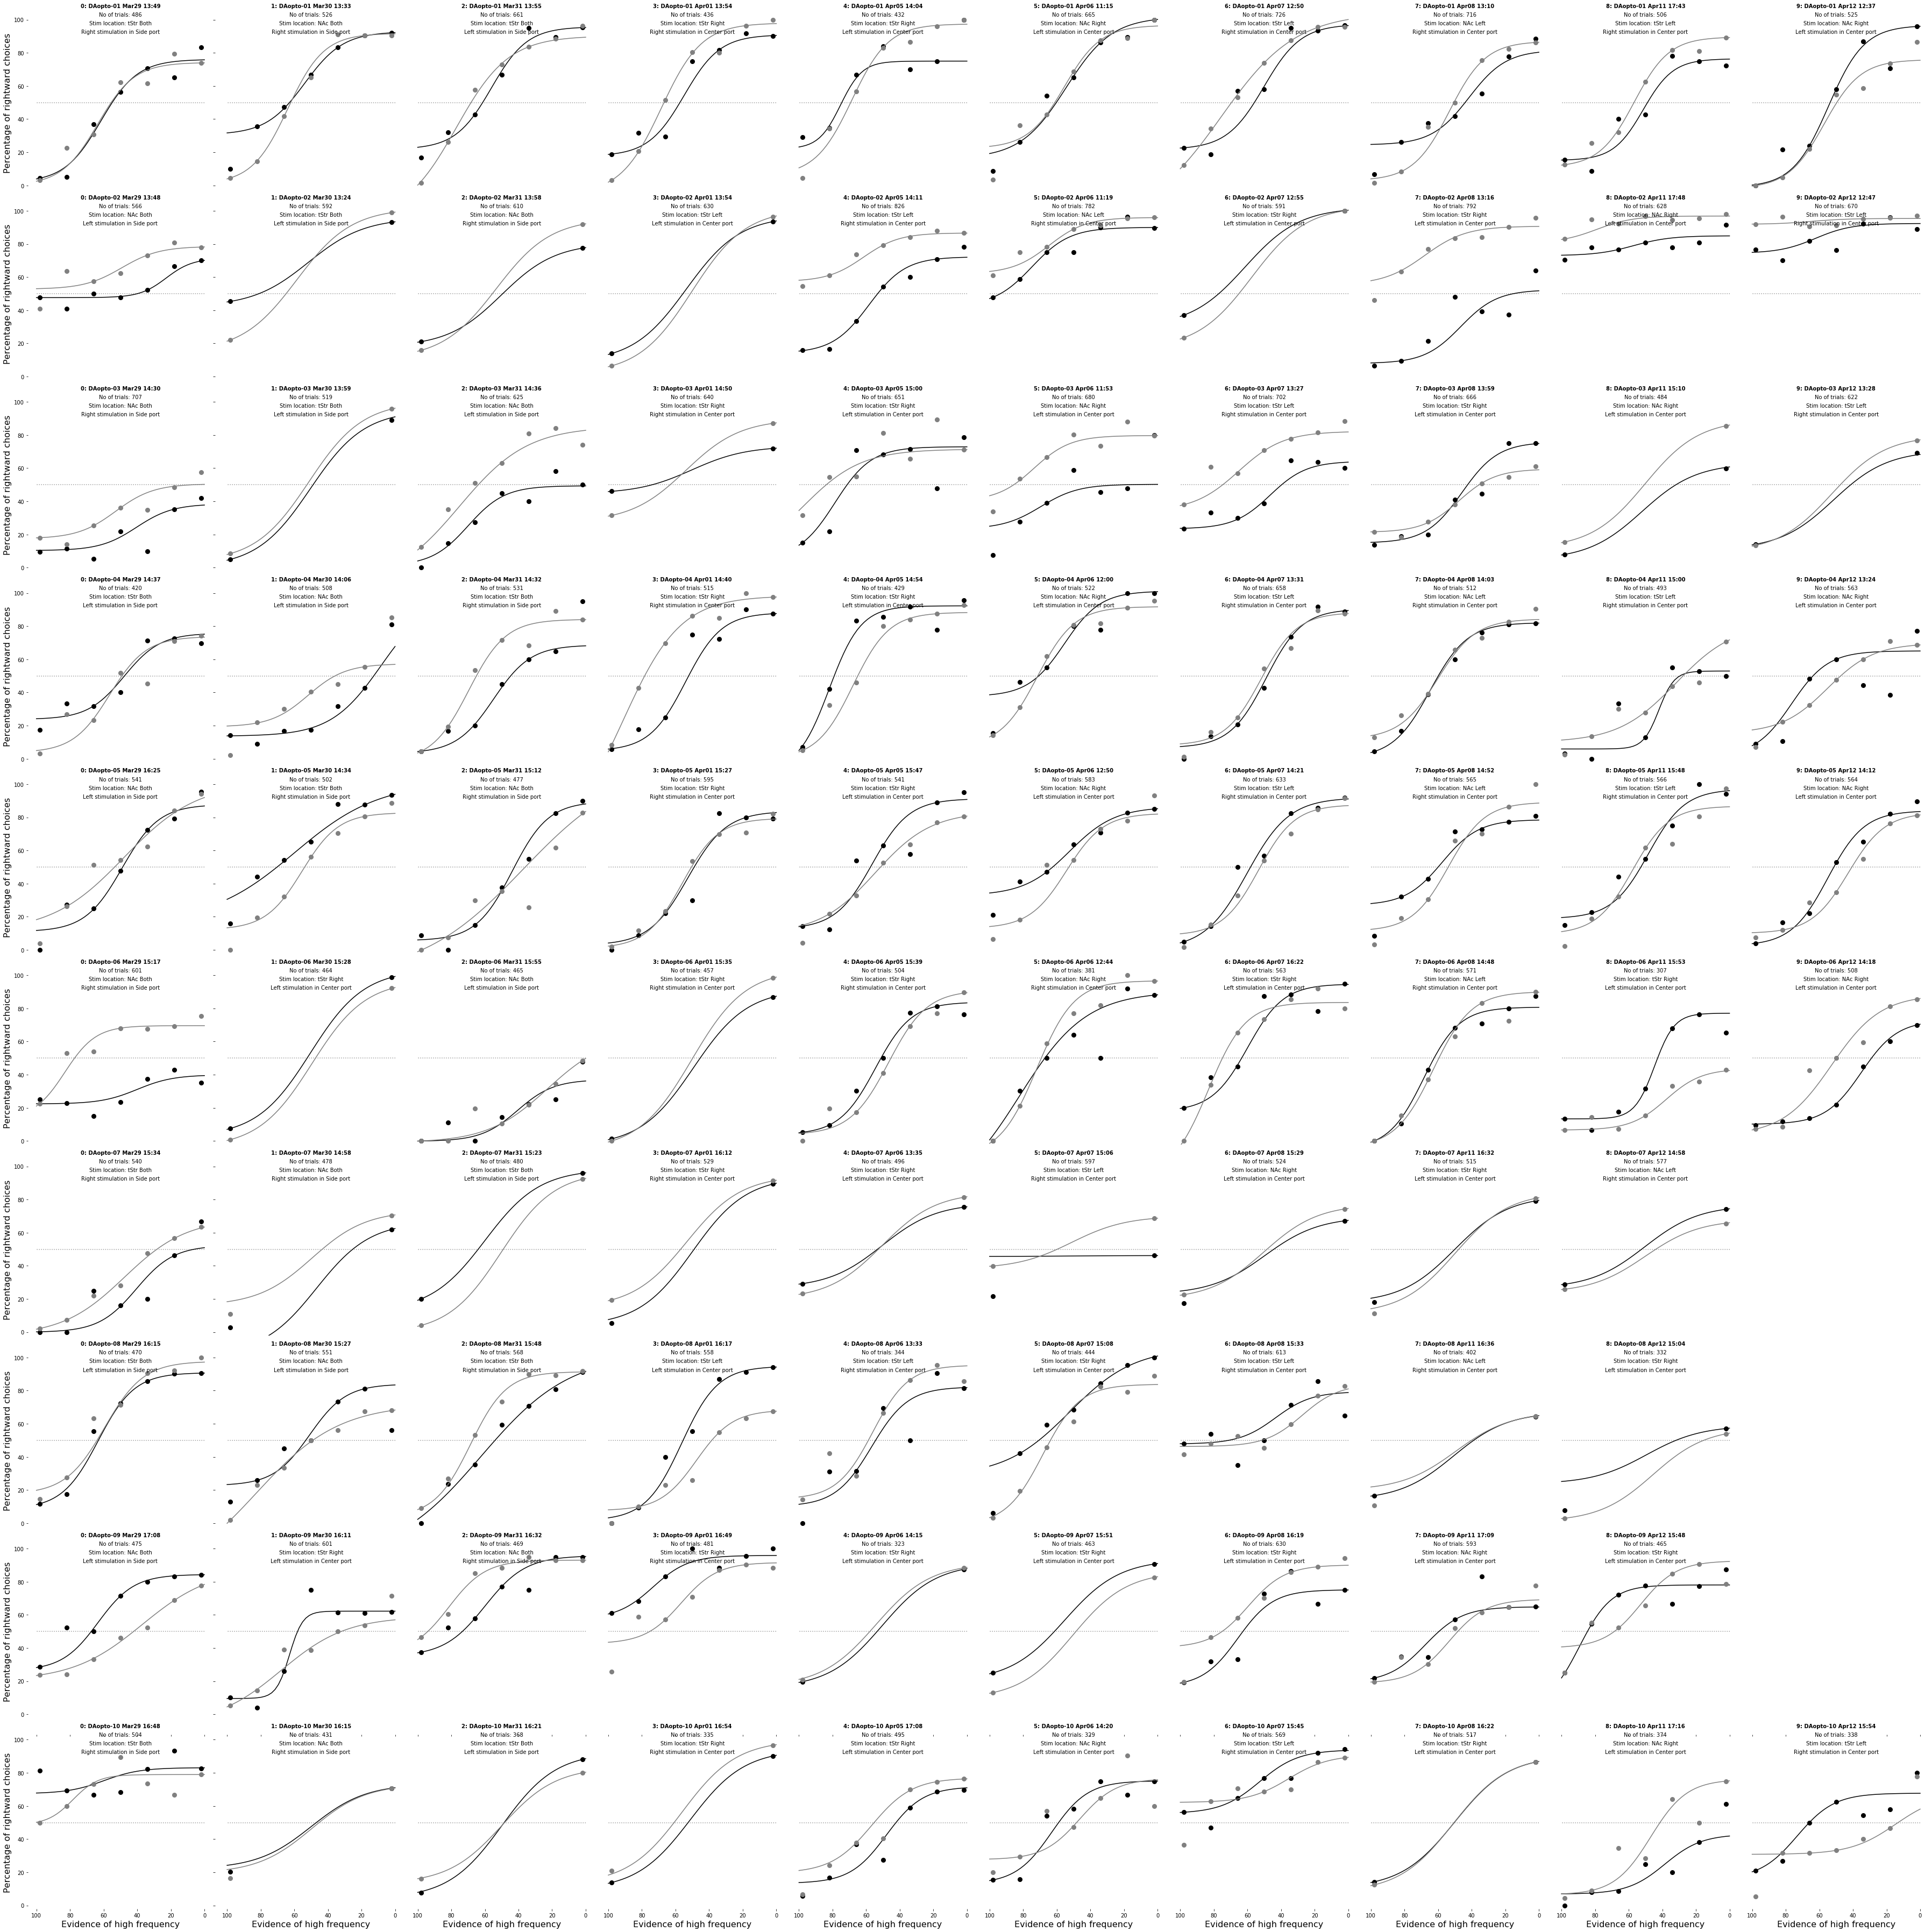

In [11]:
# Plot the data with the error bars for the random sampling, and the custom fitting
# regenerate GUI labels
BRS = ['tStr', 'NAc']
PS = ['Left', 'Right']
PI = ['Center', 'Side']

CondList = [(pulledData['TrialIndex'] < ini_trials),
            (pulledData['TrialIndex'] > ao_trials)]
ColorList = ['black', 'grey']
LabelList = ['Normal', 'After opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        # overlay fits
        for i, condition in enumerate(CondList):
            plot_utils.plot_regression(df=session_df[condition], ax=ax,
                                       color=ColorList[i], label=LabelList[i], plot_points=True)
        ax.set_ylabel('Percentage of rightward choices' , fontsize=16)    
        ax.set_xlabel('Evidence of high frequency', fontsize=16)
        
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
        ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)
        ax.text(.5,1, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)
        # Fiber location
        fl = BRS[int(session_df.iloc[0].FullGUI['FiberLocation']) - 1]
        # Side
        side = session_df.Stimulation.unique()[0]
        ax.text(.5,.95, 'Stim location: ' + fl + ' ' + side , \
                          horizontalalignment='center', transform=ax.transAxes)
        # Port stimulated
        port = PI[int(session_df.iloc[0].FullGUI['OptoState']) - 1]
        portside = PS[int(session_df.iloc[0].FullGUI['JOPSide']) - 1]
        ax.text(.5,.9, portside + ' stimulation in ' + port + ' port' , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_individual_opto_sessions_just-one-port-150.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [12]:
# calculate a general value for each session (general bias)
# group the data

In [13]:
def get_general_right_bias(df_one, df_two):
    'returns the general bias to the right, between df_one and df_two'
    # mean choices for each data frame for each difficulty
    tdone = np.array(df_one['TrialHighPerc'])
    ssone = np.array(df_one['FirstPoke'])
    _, perf_one = cuf.get_choices(ssone, tdone)
    tdtwo = np.array(df_two['TrialHighPerc'])
    sstwo = np.array(df_two['FirstPoke'])
    _, perf_two = cuf.get_choices(sstwo, tdtwo)
    
    return np.mean(perf_one) - np.mean(perf_two)

def get_random_biases(df, n_times, it, aot):
    # create array
    rblist = np.zeros(n_times)
    for i in range(n_times):
        # shuffle TrialIndexes
        df.TrialIndex = df.TrialIndex.sample(frac=1).values
        # calculate bias
        rblist[i] = get_general_right_bias(df[df.TrialIndex < it], df[df.TrialIndex > aot])
    return rblist

In [14]:
# Generate another dataset for every session
# TODO: include here random biases, and global means and std
n_times = 1000

cols = ['AnimalID', 'SessionID', 'Ntrials', 'Protocol', 'Stim', 'FiberSide',\
        'FiberArea', 'StimSide', 'StimPort', 'Contralateral', 'InitialBias', 'Bias', 'BiasToStimPort',\
        'RandomBiases', 'RandomBiasMean', 'RandomBiasStd']
data = np.empty([len(pd.unique(pulledData['SessionID'])), len(cols)], dtype=object)

for i, sessionid in enumerate(pd.unique(pulledData['SessionID'])):
    # get dataframe of the session
    session_df = pulledData[pulledData['SessionID'] == sessionid].copy()
    # get animal name
    animalid = session_df.AnimalID.unique()[0]
    # get number of trials
    ntrials = session_df.shape[0]
    # protocol
    protocol = session_df.Protocol.unique()[0]
    # is it a stimulated session?
    stim = session_df.Stimulation.unique()[0] != 'NoStimulation'
    # which fiber was plugged in
    fiberside = session_df.Stimulation.unique()[0]
    # which brain area is this fiber over
    fiberarea = BRS[int(session_df.iloc[0].FullGUI['FiberLocation']) - 1]
    # which one of the side ports, or trial type, was stimulated
    stimside = PS[int(session_df.iloc[0].FullGUI['JOPSide']) - 1]
    # in which one of the ports did stimulation occurred
    stimport = PI[int(session_df.iloc[0].FullGUI['OptoState']) - 1]
    # is the fiber contralateral to the port
    contralateral = True
    if (fiberside == stimside) or fiberside == 'Both':
        contralateral = False
    # what is the initial bias of the mouse in trials before stimulation
    ini_sess = session_df[session_df.TrialIndex < ini_trials].copy()
    initialbias = np.mean(cuf.get_choices(ini_sess['FirstPoke'], ini_sess['TrialHighPerc'])[1])
    # what is the total bias of that session after opto
    bias = get_general_right_bias(session_df[CondList[1]], session_df[CondList[0]])
    # is this bias positive towards the stimulated port?
    if stimside == 'Right':
        biastostimport = bias
    if stimside == 'Left':
        biastostimport = - bias
    # calculate random biases
    randombiases = get_random_biases(session_df, n_times, ini_trials, ao_trials)
    # random mean
    randombiasmean = np.mean(randombiases)
    # random std
    randombiasstd = np.std(randombiases)
    
    # fill
    data[i] = [animalid, sessionid, ntrials, protocol, stim, fiberside, fiberarea,\
               stimside, stimport, contralateral, initialbias, bias, biastostimport,\
               randombiases, randombiasmean, randombiasstd]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

# create dataframe
opto_df = pd.DataFrame(data, columns=cols)
update_progress(1)

Progress: [####################] 100.0%


In [21]:
# save this dataframe as it takes long to calculate
opto_df.to_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [ ]:
# read it
opto_df = pd.read_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [16]:
# plot all sessions for individual animals TODO

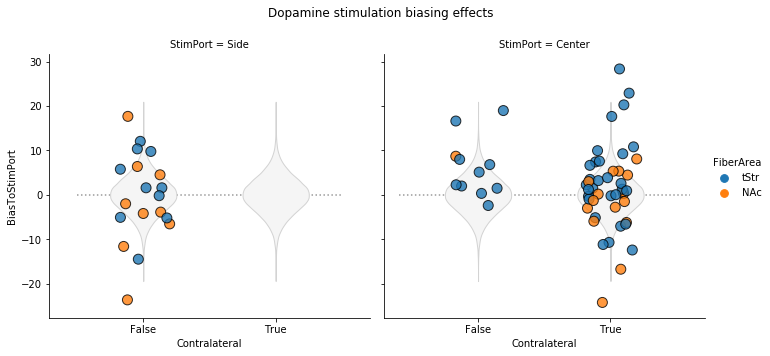

In [17]:
# plot general biases

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# TODO: filter by good performance as well (?)

rel = sns.catplot(data=opto_df[conditions], x='Contralateral', y='BiasToStimPort', hue='FiberArea', col='StimPort',
                  alpha=.8, size=5, marker='o', s=10, linewidth=1, edgecolor="k", jitter=.2)

#move overall title up
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('Dopamine stimulation biasing effects')
# add the distribution of the random biases
randbiases = np.array([item for sublist in opto_df[conditions].RandomBiases.values for item in sublist])
axs = rel.fig.axes
for ax in axs:
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for pos in ax.get_xticks():
        parts = ax.violinplot(randbiases, positions=[pos], showmeans=False, showmedians=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_zorder(-1)
            pc.set_facecolor('whitesmoke')
            pc.set_edgecolor('lightgrey')
plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

In [18]:
# THIS IS DONE ON THE TOTAL OF SESSIONS AND NOT ON THE SPECIFIC ONES FOR EACH CONDITION
# calculate the significance between experiments and the random biases
data = []
cols = ['FiberArea', 'Contralateral', 'StimPort', 'pval']
for fiber_area in opto_df[cols[0]].unique():
    for contra in opto_df[cols[1]].unique():
        for stim_port in opto_df[cols[2]].unique():
            mask = np.logical_and(opto_df.StimPort == stim_port, opto_df.Contralateral == contra)
            mask = np.logical_and(mask, opto_df.FiberArea == fiber_area)
            dist_to_compare = opto_df.BiasToStimPort[np.logical_and(mask, conditions)].values
            kt = stats.kruskal(dist_to_compare, randbiases)
#             print(', '.join([fiber_area, str(contra), stim_port]) + ':\t\tpvalue: ' + str(kt.pvalue) )
            data.append([fiber_area, contra, stim_port, kt.pvalue])
pvals_df = pd.DataFrame(data, columns=cols)
pvals_df

In [76]:
opto_df[np.logical_and(conditions, opto_df.FiberArea=='tStr')].sort_values(by=['BiasToStimPort'])

,AnimalID,SessionID,Ntrials,Protocol,Stim,FiberSide,FiberArea,StimSide,StimPort,Contralateral,InitialBias,Bias,BiasToStimPort,RandomBiases,RandomBiasMean,RandomBiasStd
96,DAopto-10,DAopto-10 Apr12 15:54,338,Aud_Psycho,True,Left,tStr,Right,Center,True,50.4166,-12.3882,-12.3882,"[2.100660248844001, -4.256345124448885, 1.7177...",0.278782,5.67278
84,DAopto-09,DAopto-09 Apr08 16:19,630,Aud_Psycho,True,Right,tStr,Left,Center,True,55.046,11.1464,-11.1464,"[1.8009489362567876, 0.23322057535542484, 0.20...",0.0197011,4.03979
24,DAopto-03,DAopto-03 Apr05 15:00,651,Aud_Psycho,True,Right,tStr,Left,Center,True,53.4028,10.6723,-10.6723,"[-3.334618440258268, -2.769002311938287, 1.096...",0.0326493,4.48343
48,DAopto-05,DAopto-05 Apr11 15:48,566,Aud_Psycho,True,Left,tStr,Right,Center,True,57.9548,-7.03408,-7.03408,"[2.3860036053750306, -0.8364648676462778, -6.3...",-0.0653986,3.76484
91,DAopto-10,DAopto-10 Apr05 17:08,495,Aud_Psycho,True,Right,tStr,Left,Center,True,40.6262,6.56671,-6.56671,"[3.8428319184723563, -4.119732531413739, 3.641...",0.0978657,4.6119
46,DAopto-05,DAopto-05 Apr07 14:21,633,Aud_Psycho,True,Left,tStr,Right,Center,True,55.1116,-5.12169,-5.12169,"[-4.056727142034752, -3.2109304481094227, -3.2...",0.209028,3.70919
82,DAopto-09,DAopto-09 Apr06 14:15,323,Auditory,True,Right,tStr,Left,Center,True,53.6092,0.93487,-0.93487,"[-3.7500537200687205, -1.09060744653965, 4.510...",0.131179,4.73515
75,DAopto-08,DAopto-08 Apr08 15:33,613,Aud_Psycho,True,Left,tStr,Right,Center,True,58.427,-0.304767,-0.304767,"[-2.7452097578082117, -1.5739075026697336, 5.1...",0.0325565,4.59357
4,DAopto-01,DAopto-01 Apr05 14:04,432,Aud_Psycho,True,Right,tStr,Left,Center,True,65.6355,0.1986,-0.1986,"[6.5402205292955955, -1.9078077712567136, 5.60...",0.0757996,4.14044
64,DAopto-07,DAopto-07 Apr06 13:35,496,Auditory,True,Right,tStr,Left,Center,True,52.2866,-0.0527866,0.0527866,"[-2.073737987877294, -3.380800888754237, -5.09...",0.0468965,4.34066


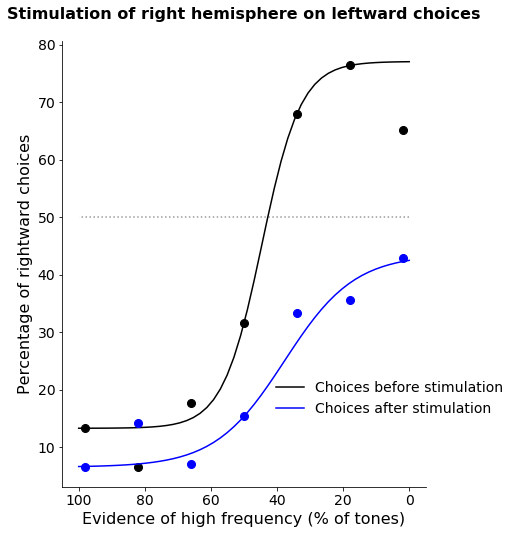

In [103]:
# get a nice example of a shift
example_session = 'DAopto-06 Apr11 15:53'

CondList = [(pulledData['TrialIndex'] < ini_trials),
            (pulledData['TrialIndex'] > ao_trials)]
ColorList = ['black', 'blue']
LabelList = ['Choices before stimulation', 'Choices after stimulation']

fig, ax = plt.subplots(1, 1,
                        figsize=(7, 7),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

# ax.axis('off')

session_df = pulledData[pulledData['SessionID'] == example_session]
        
ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)


# overlay fits
for i, condition in enumerate(CondList):
    plot_utils.plot_regression(df=session_df[condition], ax=ax,
                               color=ColorList[i], label=LabelList[i], plot_points=True)
#axs[counter].set_ylabel('')
#axs[counter].set_xlabel('')
# ax.axis('on')
# remove some ticks
# ax.tick_params(top=False, bottom='on', left='on', right=False)

ax.set_ylabel('Percentage of rightward choices' , fontsize=16)
    
ax.set_xlabel('Evidence of high frequency (% of tones)', fontsize=16)

# ax.set_ylim(-2., 102.)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(.9, .25), loc='upper center', borderaxespad=0., ncol=1, frameon=False, fontsize=14)
# ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
#                labelleft='on', labelbottom='on')
# get rid of the frame
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.tight_layout()

ax.invert_xaxis()

#         ax.get_legend().remove()
ax.text(.5,1.05, 'Stimulation of right hemisphere on leftward choices', \
                  horizontalalignment='center', fontweight='bold', transform=ax.transAxes, fontsize=16)
# ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
#                   horizontalalignment='center', transform=ax.transAxes)
# ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
#                   horizontalalignment='center', transform=ax.transAxes, fontsize=16)
# ax.text(.5,.95, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
#                   horizontalalignment='center', transform=ax.transAxes, fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(outputDir + output_directory_name + '_just-one-port-150_example_session.pdf', transparent=True, bbox_inches='tight')
plt.show()


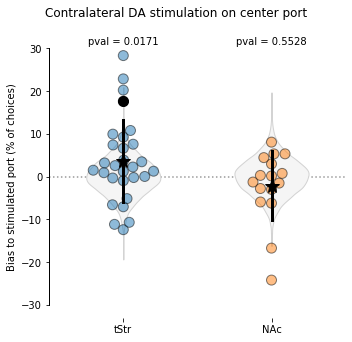

In [93]:
# Focus only on the contralateral stimulation in the center

hor = ['tStr', 'NAc']
# TODO make a palette

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')

# plot
rel = sns.catplot(data=opto_df[conditions], x='FiberArea', y='BiasToStimPort', hue='FiberArea',
                  alpha=.5, size=5, marker='o', s=10, linewidth=1, edgecolor="k",# jitter=.15,
                  hue_order=hor,
                  kind='swarm',
                  height=15, aspect=8/8)

#move overall title up
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle('Contralateral DA stimulation on center port')
# add the distribution of the random biases, and mean and std
axs = rel.fig.axes
for ax in axs:
    ax.set_ylabel('Bias to stimulated port (% of choices)')
    ax.set_xlabel('')
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for i, pos in enumerate(ax.get_xticks()):
        facond = np.logical_and(conditions, opto_df.FiberArea==hor[i])
        randbiases = np.array([item for sublist in opto_df[facond].RandomBiases.values for item in sublist])
        parts = ax.violinplot(randbiases, positions=[pos], showmeans=False, showmedians=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_zorder(-2)
            pc.set_facecolor('whitesmoke')
            pc.set_edgecolor('lightgrey')
        
        # mean and std
        dist_to_compare = opto_df[facond].BiasToStimPort.values
        xm = np.mean(dist_to_compare)
        xstd = np.std(dist_to_compare)
        ax.plot(i, xm, '*', color='k', zorder=50, markersize=15)
        ax.plot([i, i], [xm - xstd, xm + xstd], '-', color='k', zorder=50, linewidth=3)

        # add the significance
        pval = stats.kruskal(dist_to_compare, randbiases).pvalue
        ax.text(x=i, y=ax.get_ylim()[1], s='pval = {:.6}'.format(str(pval)),
                horizontalalignment='center')
        
    # keep only y axis and floating x ticks
    ax.set_frame_on(False)
    xmin, xmax = ax.get_xaxis().get_view_interval()
#     ymin, ymax = ax.get_yaxis().get_view_interval()
    ax.plot((xmin, xmin), (-30, 30), color='black', linewidth=1)

# highlight the example session
xm = opto_df[opto_df.SessionID == example_session].BiasToStimPort.values
ax.plot(0, xm, 'o', color='k', zorder=50, markersize=10)
        
plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases_simple_center-contralateral.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

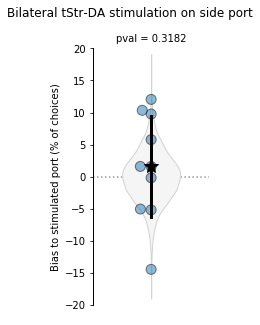

In [73]:
# Show that it is not aversive
# Focus only on the contralateral stimulation in the center

hor = ['tStr', 'NAc']
# TODO make a palette

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
conditions = np.logical_and(conditions, opto_df.Contralateral==False)
conditions = np.logical_and(conditions, opto_df.StimPort=='Side')
conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')

# plot
rel = sns.catplot(data=opto_df[conditions], x='FiberArea', y='BiasToStimPort', hue='FiberArea',
                  alpha=.5, size=5, marker='o', s=10, linewidth=1, edgecolor="k",# jitter=.15,
                  hue_order=hor,
                  kind='swarm',
                  height=15, aspect=4/8)

#move overall title up
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle('Bilateral tStr-DA stimulation on side port')
# add the distribution of the random biases, and mean and std
axs = rel.fig.axes
for ax in axs:
    ax.set_ylabel('Bias to stimulated port (% of choices)')
    ax.set_xlabel('')
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for i, pos in enumerate(ax.get_xticks()):
        facond = np.logical_and(conditions, opto_df.FiberArea==hor[i])
        randbiases = np.array([item for sublist in opto_df[facond].RandomBiases.values for item in sublist])
        parts = ax.violinplot(randbiases, positions=[pos], showmeans=False, showmedians=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_zorder(-2)
            pc.set_facecolor('whitesmoke')
            pc.set_edgecolor('lightgrey')
        
        # mean and std
        dist_to_compare = opto_df[facond].BiasToStimPort.values
        xm = np.mean(dist_to_compare)
        xstd = np.std(dist_to_compare)
        ax.plot(i, xm, '*', color='k', zorder=50, markersize=15)
        ax.plot([i, i], [xm - xstd, xm + xstd], '-', color='k', zorder=50, linewidth=3)

        # add the significance
        pval = stats.kruskal(dist_to_compare, randbiases).pvalue
        ax.text(x=i, y=ax.get_ylim()[1], s='pval = {:.6}'.format(str(pval)),
                horizontalalignment='center')
    
    # keep only y axis and floating x ticks
    ax.set_frame_on(False)
    xmin, xmax = ax.get_xaxis().get_view_interval()
#     ymin, ymax = ax.get_yaxis().get_view_interval()
    ax.plot((xmin, xmin), (-20, 20), color='black', linewidth=1)
    ax.get_xaxis().set_visible(False)

plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases_simple_side-bilateral.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

In [44]:
# include non-stimulated sessions to see if there is something general about correcting bias.
# If so, do not include those sessions 

### Analysis of tStr unilateral stimulation

In [53]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [54]:
# Select stimulation in tStr
fib_loc_num = 1
fln_mask = [x['FiberLocation'] == fib_loc_num for x in pulledData.FullGUI]
pulledData = pulledData.iloc[fln_mask]

In [55]:
# Because we are going to look at the subsequent trial,
# I will 'hack' the dataframe and classify as optostimulated trials,
# the in which the stimulation happened in the trial before.
# That way I can make use of the functions available for analysis

pulledData.OptoStim = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)

In [56]:
# Select only those trials where the previous trial is a success
pulledData = pulledData[pulledData.PrevTrialSuccess == 1]

In [57]:
# Select only those trials where the previous trial is contralateral to the fiber
# 1 is left poke
# 2 is right poke

pulledData['PreviousSide'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            side_prev = pulledData.loc[idx_prev].TrialSide
        else:
            side_prev = np.nan

        pulledData.at[idx, 'PreviousSide'] = side_prev

In [58]:
# Do the selection
idxs_to_keep = []
for session_id in pulledData.SessionID.unique():
    session_data = pulledData[pulledData.SessionID == session_id]
    stim_side = session_data.Stimulation.unique()[0]
    if stim_side == 'Right':
        idxs_to_keep.append(session_data[session_data.PreviousSide == 1].index)
    if stim_side == 'Left':
        idxs_to_keep.append(session_data[session_data.PreviousSide == 2].index)

# flatten
idxs_to_keep_flat = [item for sublist in idxs_to_keep for item in sublist]

#select
pulledData = pulledData.loc[idxs_to_keep_flat]

In [59]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [60]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [61]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = pulledData[pulledData['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [62]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
# random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
#     random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

In [63]:
pulledData['PreviousOpto'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            opto_prev = pulledData.loc[idx_prev].OptoStim
        else:
            opto_prev = np.nan

        pulledData.at[idx, 'PreviousOpto'] = opto_prev

Progress: [####################] 100.0%


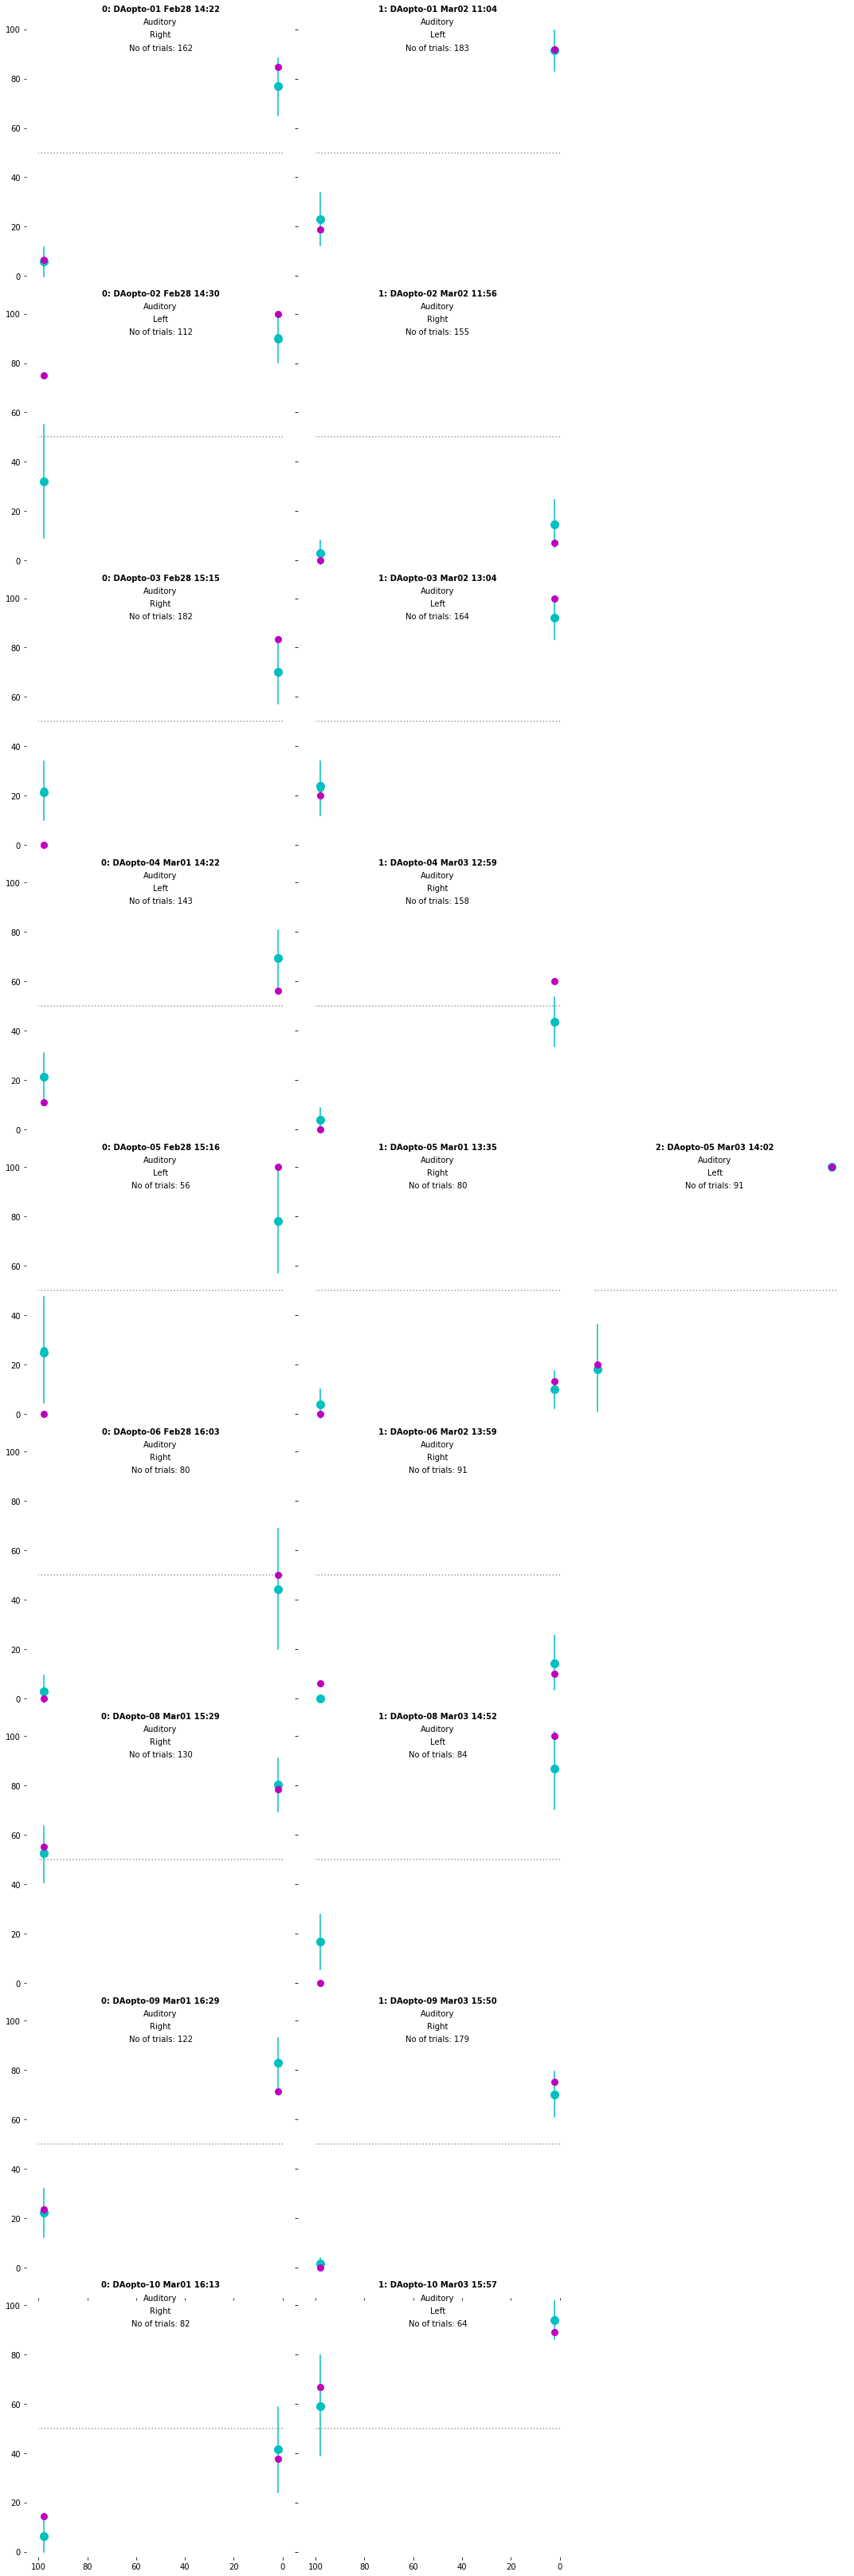

In [65]:
# Plot the data with the error bars for the random sampling

# CondList = [(pulledData['PreviousOpto']==0),
#             (pulledData['PreviousOpto']==1)]
ColorList = ['c', 'm']
LabelList = ['Previous Normal', 'Previous Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()
# n_cols = 2

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
        # overlay fits
#         for i, condition in enumerate(CondList):
#             plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
#                                        color=ColorList[i], label=LabelList[i], plot_points=True)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_previous_tStr.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

### nAc stimulation

In [57]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [58]:
#Subselect dataset psychometric
pulledData = pulledData[pulledData.Protocol == "Aud_Psycho"]

In [59]:
# Select stimulation in tStr
fib_loc_num = 2
fln_mask = [x['FiberLocation'] == fib_loc_num for x in pulledData.FullGUI]
pulledData = pulledData.iloc[fln_mask]

In [60]:
# Because we are going to look at the subsequent trial,
# I will 'hack' the dataframe and classify as optostimulated trials,
# the in which the stimulation happened in the trial before.
# That way I can make use of the functions available for analysis

pulledData.OptoStim = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)

In [61]:
# MAYBE CHANGE THIS FOR NAc or consider analysing wrong trials as well

# Select only those trials where the previous trial is a success
pulledData = pulledData[pulledData.PrevTrialSuccess == 1]

In [62]:
# Find where the previous side happened
# 1 is left poke
# 2 is right poke

pulledData['PreviousSide'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            side_prev = pulledData.loc[idx_prev].TrialSide
        else:
            side_prev = np.nan

        pulledData.at[idx, 'PreviousSide'] = side_prev

In [63]:
# Select only one side. This is faster and uglier
selected_prev_side = 1
pulledData = pulledData[pulledData.PreviousSide == selected_prev_side]

In [64]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [65]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [66]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = pulledData[pulledData['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [67]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
# random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
#     random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

In [68]:
pulledData['PreviousOpto'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            opto_prev = pulledData.loc[idx_prev].OptoStim
        else:
            opto_prev = np.nan

        pulledData.at[idx, 'PreviousOpto'] = opto_prev

Progress: [####################] 100.0%


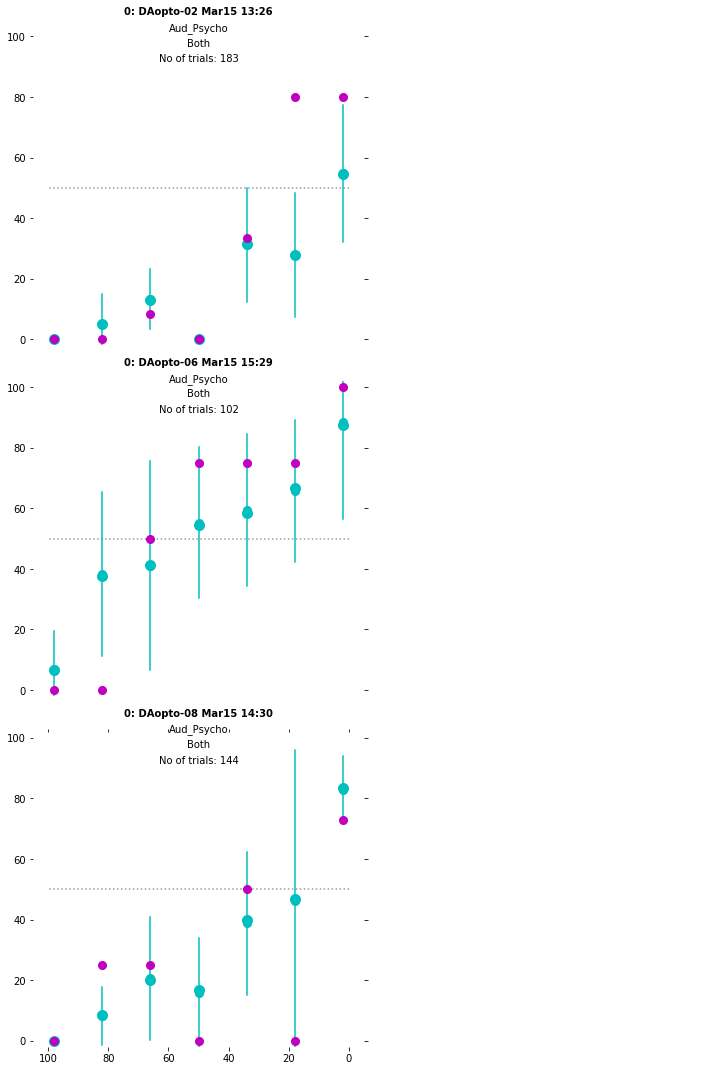

In [69]:
# Plot the data with the error bars for the random sampling

# CondList = [(pulledData['PreviousOpto']==0),
#             (pulledData['PreviousOpto']==1)]
ColorList = ['c', 'm']
LabelList = ['Previous Normal', 'Previous Opto']

# n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()
n_cols = 2

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)

if selected_prev_side == 1:
    sps_str = 'left'
if selected_prev_side == 2:
    sps_str = 'right'

plt.savefig(outputDir + output_directory_name + \
            '_difficulty_significance_for_individual_opto_sessions_previous_nAc_previous-' + sps_str + '.pdf',
            transparent=True, bbox_inches='tight')

plt.show(fig)